# Test MNIST data loading

In [1]:
import torch
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet', 'network')))

from datasets import MNIST
from encoding import get_poisson, get_bernoulli

%matplotlib inline

## Load MNIST training data

The `datasets.MNIST` object will handle data loading and saving.

In [2]:
# Uncomment and run this carefully!
# !rm -r ../../data

In [3]:
path = os.path.join('..', '..', 'data')  # Where to store the data
mnist = MNIST(path=path)  # Instantiate MNIST object

In [4]:
# Load training data.
images, labels = mnist.get_train()

Loading images from serialized object file.

Loading labels from serialized object file.



In [5]:
print('Shape of training images:', images.shape)
print('Shape of training labels:', labels.shape)

Shape of training images: torch.Size([60000, 28, 28])
Shape of training labels: torch.Size([60000])


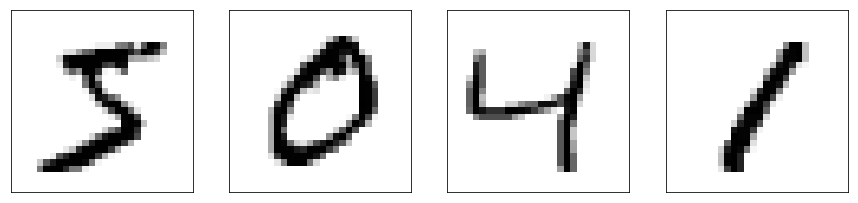

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(15, 8))

for i, ax in enumerate(axes):
    ax.matshow(images[i], cmap='binary')
    ax.set_xticks(()); ax.set_yticks(());

If we want to load these datasets again, `bindsnet` can automatically load them from serialized object files on disk (which is much faster!).

In [7]:
del images, labels  # Delete data from memory

# Reload data from serialized object files.
images, labels = mnist.get_train()

Loading images from serialized object file.

Loading labels from serialized object file.



As a sanity check, let's do the same steps for the test data.

In [8]:
# Load test data.
test_images, test_labels = mnist.get_test()

Loading images from serialized object file.

Loading labels from serialized object file.



In [9]:
print('Shape of test images:', test_images.shape)
print('Shape of test labels:', test_labels.shape)

Shape of test images: torch.Size([10000, 28, 28])
Shape of test labels: torch.Size([10000])


In [10]:
del test_images, test_labels  # Delete data from memory

# Reload data from serialized object files.
test_images, test_labels = mnist.get_train()

Loading images from serialized object file.

Loading labels from serialized object file.



## Poisson spike encoding

The function `encoding.get_poisson` takes in a dataset of observations (e.g., `images` as in above), and returns a generator which yields Poisson spike trains of dimensionality `[time, n_1, ..., n_k]`, where `time` is specified in the function call, and `n_1, ..., n_k` corresponds to the dimensionality of the observations matrix.

As a shorthand, let $\mathbf{X}$ = the observation matrix (the dataset; e.g., the MNIST handwritten digits), and let $\mathbf{y}$ = the target vector (the ground truth targets; e.g., the corresponding labels of the MNIST digit data).

In [11]:
X, y = mnist.get_train()  # Load the training data

min_interspike = 2  # Minimum typical inter-spike interval
X = X / (255 * min_interspike)  # Normalize and enforce typical ISI

time = 1000  # How many timesteps per input?

# Creates a "data loader": yields Poisson spike train-encoded data.
data_loader = get_poisson(X, time=time)

Loading images from serialized object file.

Loading labels from serialized object file.



To fetch an item from the _data loader_, call `next(data_loader)`.

In [12]:
spike_trains = next(data_loader)  # Fetch an encoded datum

Now, let's plot the original digit against the spike trains, summed up over the time axis. We expect that these should look very similar, albeit from the randomness introduced by the non-deterministic Poisson spiking process.

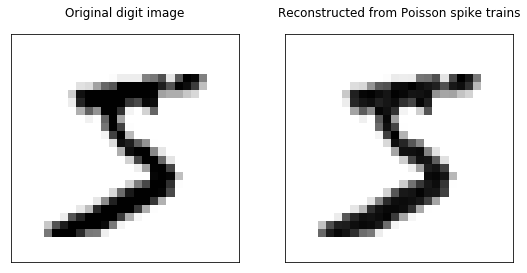

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))

axes[0].matshow(X[0] * (255 * min_interspike), cmap='binary')
axes[1].matshow(spike_trains.sum(0), cmap='binary')

axes[0].set_title('Original digit image')
axes[1].set_title('Reconstructed from Poisson spike trains')

for ax in axes:
    ax.set_xticks(())
    ax.set_yticks(())

Let's inspect the raw spikes over the 1,000 timesteps.

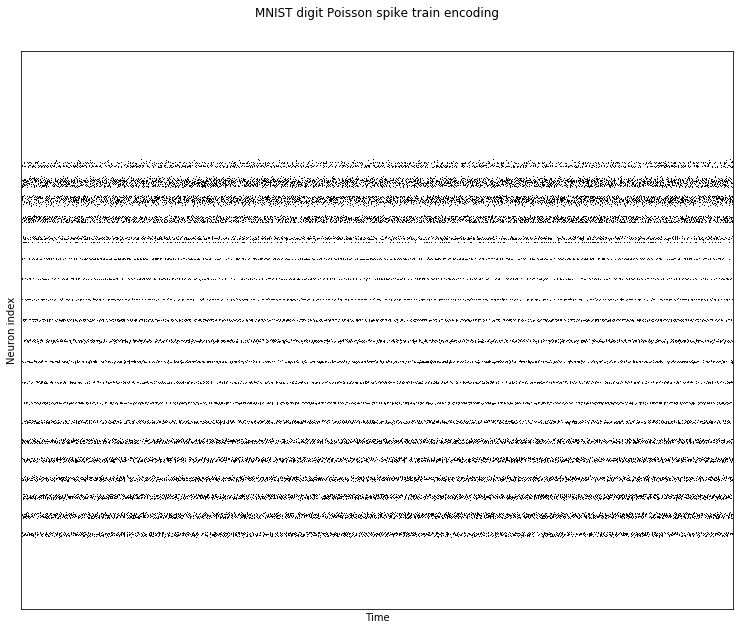

In [14]:
plt.rcParams['figure.figsize'] = (10, 10)

plt.matshow(spike_trains.view(time, -1).t(), cmap='binary')
plt.xticks(()); plt.yticks(())
plt.xlabel('Time'); plt.ylabel('Neuron index')
plt.title('MNIST digit Poisson spike train encoding');

## Bernoulli spike encoding

Similar to above, `encoding.get_bernoulli` requires the same arguments as `encoding.get_poisson` and yields `torch.Tensor`s (or `torch.cuda.Tensor`s) of shape `[time, n_1, ..., n_k]`, where `[n_1, ..., n_k]` refers to the dimensionality of the input data. The returned `Tensor`s correspond to spike trains in which each neuron fires on each time step with probability proportion to the magnitude of the input data.

There is an additional keyword argument, `max_prob`, which sets the maximum Bernoulli success probability, and rescales all other success probabilities proportionately. For example, if `max_prob=0.1`, then the maximum expected firing rate is $\frac{1}{10}$, and all other expected firing rates (before rescaling) are multiplied by 0.1.

In [15]:
X, y = mnist.get_train()  # Load the training data

time = 1000  # How many timesteps per input?

# Creates a "data loader": yields Poisson spike train-encoded data.
data_loader = get_bernoulli(X, time=time, max_prob=0.25)  # Max expected firing rates is once per four timesteps

Loading images from serialized object file.

Loading labels from serialized object file.



In [16]:
spike_trains = next(data_loader)  # Fetch an encoded sample

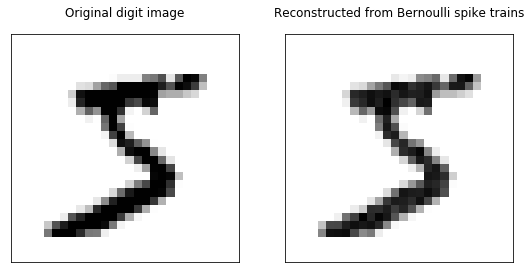

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(9, 9))

axes[0].matshow(X[0] * (255 * min_interspike), cmap='binary')
axes[1].matshow(spike_trains.sum(0), cmap='binary')

axes[0].set_title('Original digit image')
axes[1].set_title('Reconstructed from Bernoulli spike trains')

for ax in axes:
    ax.set_xticks(())
    ax.set_yticks(())

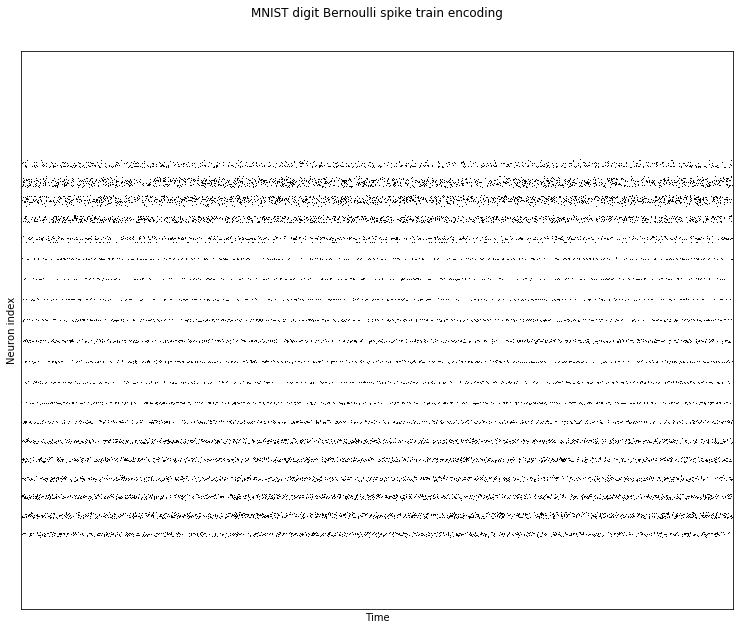

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)

plt.matshow(spike_trains.view(time, -1).t(), cmap='binary')
plt.xticks(()); plt.yticks(())
plt.xlabel('Time'); plt.ylabel('Neuron index')
plt.title('MNIST digit Bernoulli spike train encoding');